In [1]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, config_enumerate, TraceEnum_ELBO, infer_discrete
import pyro.distributions as dist

import matplotlib.pyplot as plt

In [2]:
#### Initialization
# enable validation (e.g. validate parameters of distributions)
assert pyro.__version__.startswith('1.5.1')
pyro.enable_validation(True)

# random seeding
pyro.set_rng_seed(101)
torch.manual_seed(123)

# clear the param store in case we're in a REPL
pyro.clear_param_store()


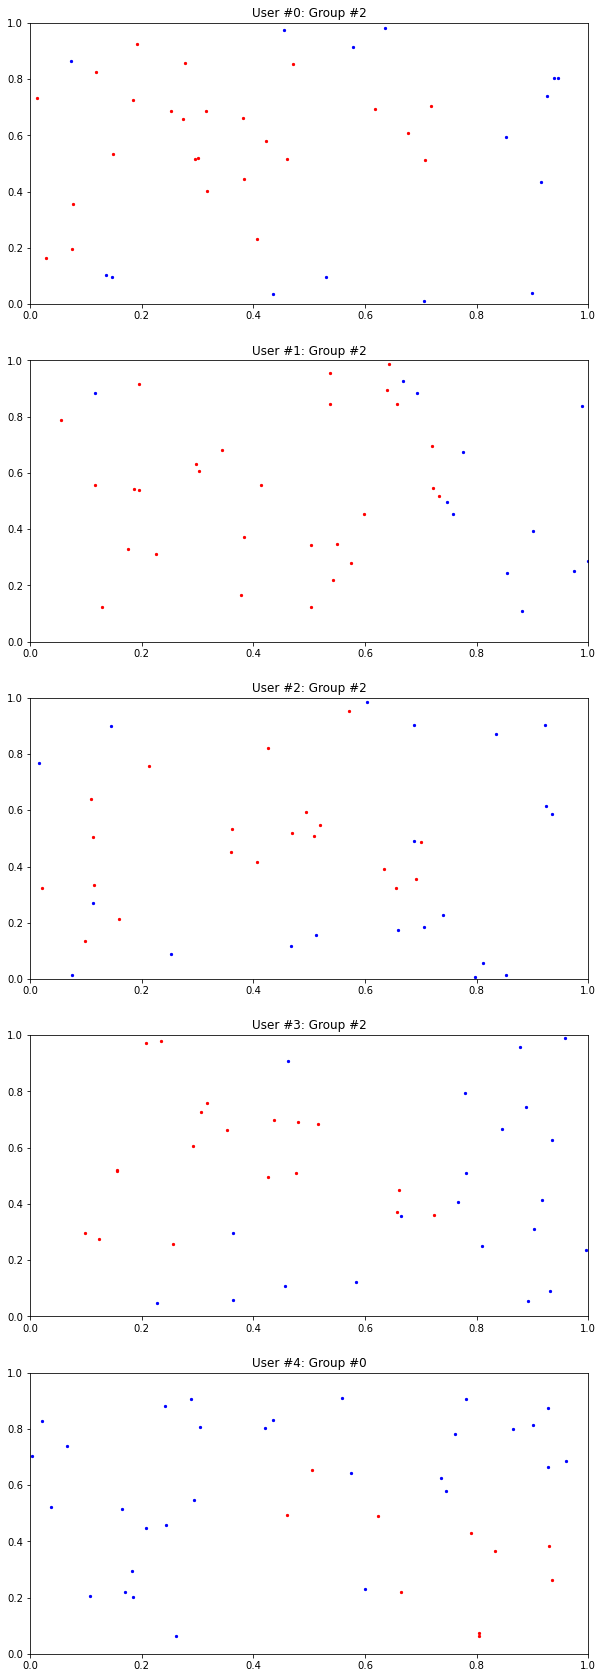

In [3]:
#### Data generation
n_groups = 3
n_users = 5
n_items = 40
d_kpi = 2

def gen_items(n_users, n_items, d_kpi):
    user_items = []
    for _ in range(n_users):
        user_items.append(torch.rand(n_items, d_kpi))
    return user_items

user_items = gen_items(n_users, n_items, d_kpi)

def gen_data(true_beta, true_scale, user_items):
    '''
    inputs:
        true_beta: 2D torch tensor of size n_groups-by-d_kpi (implicit param)
        true_scale: 1D torch tensor of length n_groups
        user_items: list (size-n_users) of 
            2D torch tensor of size n_items-by-d_kpi (implicit param)
    '''
    n_groups = true_beta.shape[0]
    true_p_grp = torch.ones(n_groups)/n_groups
    n_users = len(user_items)
    user_ID = []
    user_labels = [[] for _ in range(n_users)]
    for i_user in range(n_users):
        uid = pyro.sample('fix_uid_{}'.format(i_user), dist.Categorical(true_p_grp))
        user_ID.append(uid)
        center, scale = true_beta[uid], true_scale[uid]
        
        items = user_items[i_user]
        for i_item in range(items.shape[0]):
            distance = torch.linalg.norm(scale*(center-items[i_item]))**4.0
            user_labels[i_user].append(
                pyro.sample('fix_ulab_{}_{}'.format(i_user, i_item), 
                    dist.Bernoulli(math.exp(-distance))
                )
            )
    return user_ID, user_labels

true_beta = torch.rand(n_groups, d_kpi)
true_scale = 2.0*torch.ones(n_groups)
user_ID, user_labels = gen_data(true_beta, true_scale, user_items)

## visualize the data
fig, axes = plt.subplots(n_users, 1, figsize=(10, 30))
code_color = {0:'b', 1:'r'}
msize = 5
for i_user in range(n_users):
    axes[i_user].set_title('User #{}: Group #{}'.format(i_user, user_ID[i_user]))
    axes[i_user].set_xlim([0, 1])
    axes[i_user].set_ylim([0, 1])
    for i_it in range(n_items):
        axes[i_user].scatter(user_items[i_user][i_it, 0], user_items[i_user][i_it, 1], color=code_color[int(user_labels[i_user][i_it])], s=msize)
plt.show()
        

In [15]:
#### Define model and guide
n_groups = 2
@config_enumerate(default='sequential')
def model(data):
    user_items, user_labels = data

    true_p_grp = torch.ones(n_groups)/n_groups
    true_beta = pyro.param("true_beta", torch.rand(n_groups, d_kpi),
                         constraint=constraints.unit_interval)
    true_scale = pyro.param("true_scale", torch.ones(n_groups)*2.5,
                         constraint=constraints.interval(1.0, 4.0))
    # n_users = len(user_items)
    user_ID = []
    # user_labels = [[] for _ in range(n_users)]
    for i_user in range(n_users):
        uid = pyro.sample('uid_{}'.format(i_user), dist.Categorical(true_p_grp))
        user_ID.append(uid)
        center, scale = true_beta[uid], true_scale[uid]
        
        items = user_items[i_user]
        for i_item in range(items.shape[0]):
            distance = torch.linalg.norm(scale*(center-items[i_item]))**4.0
            label = pyro.sample('ulab_{}_{}'.format(i_user, i_item), 
                dist.Bernoulli(torch.exp(-distance)),
                obs=user_labels[i_user][i_item]
            )
            # user_labels[i_user].append(label)
    return user_ID

def guide(data):
    true_p_grp = torch.ones(n_groups)/n_groups
    for i_user in range(n_users):
        uid = pyro.sample('uid_{}'.format(i_user), dist.Categorical(true_p_grp))

In [16]:
#### training

data = (user_items, user_labels)

pyro.clear_param_store()

# collect history
from collections import defaultdict
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

# setup the optimizer
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO(max_plate_nesting=0))
n_steps = 1000

# do gradient steps
losses = []
for step in range(n_steps):
    losses.append(svi.step(data))
    if step % 100 == 0:
        print('.', end='')
        

..........

In [17]:
for name, value in pyro.get_param_store().named_parameters():
    print(name)
    print(value)

true_beta
tensor([[ 1.8476, -0.1232],
        [-1.4860,  0.2627]], requires_grad=True)
true_scale
tensor([-0.7974, -0.6621], requires_grad=True)


In [18]:

elbo = TraceEnum_ELBO(max_plate_nesting=0)
elbo.loss(model, guide, data)

206.3357696533203

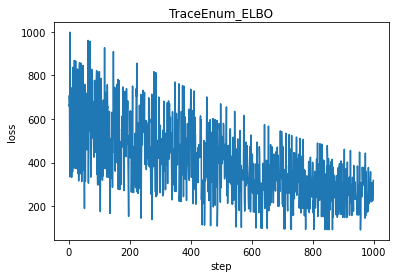

In [19]:
#### post-process

# print loss history
plt.plot(losses)
plt.title("TraceEnum_ELBO")
plt.xlabel("step")
plt.ylabel("loss")

# grab the learned variational parameters
beta_hat = pyro.param("true_beta")
scale_hat = pyro.param("true_scale")


In [20]:
print(beta_hat)
print(scale_hat)

tensor([[0.8638, 0.4692],
        [0.1845, 0.5653]], grad_fn=<ClampBackward>)
tensor([1.9317, 2.0208], grad_fn=<AddBackward0>)
[tensor(1), tensor(0), tensor(1), tensor(1), tensor(1)]


In [22]:
#### MAP predictor
from pyro import poutine

guide_trace = poutine.trace(guide).get_trace(data)  # record the globals
trained_model = poutine.replay(model, trace=guide_trace)  # replay the globals

def classifier(data, temperature=0):
    inferred_model = infer_discrete(trained_model, temperature=temperature,
                                    first_available_dim=-1)  # avoid conflict with data plate
    trace = poutine.trace(inferred_model).get_trace(data)
    return [trace.nodes["uid_{}".format(i)]["value"] for i in range(n_users)]

print(classifier(data))



[tensor(0), tensor(0), tensor(0), tensor(0), tensor(1)]
